In [1]:
%cd '/home/danbi/userdata/DANBI/gugakwon/Yeominrak'
%load_ext autoreload
%autoreload 2

from pathlib import Path
import music21
from music21 import converter, stream, note as m21_note 
from typing import List, Set, Dict, Tuple
import torch
import torch.nn as nn
from collections import defaultdict, Counter
import copy
import math
import numpy as np
from matplotlib import pyplot as plt

from trainer import Trainer, RollTrainer, RollPitchTrainer
from torch.utils.data import DataLoader
from yeominrak_processing import Part, AlignedScore, SamplingScore, Tokenizer, pack_collate, pad_collate, CNNScore, SamplingScore2
import random as random
from model import RollSeq2seq, QkvRollSeq2seq, CNNModel, RollPitchSeq2seq
import random as random
from loss import nll_loss, focal_loss
from torch.nn.utils.rnn import pack_sequence, PackedSequence, pad_packed_sequence, pack_padded_sequence, pad_sequence
from decode import SampingDecoder
from evaluation import fill_pitches

/home/danbi/userdata/DANBI/gugakwon/Yeominrak


In [ ]:
max_len = 300
train_dataset = CNNScore(slice_measure_num = 2, sample_len = 1000, is_valid = False, is_modify_pitch=False)
val_dataset = CNNScore(slice_measure_num = 2, is_valid = True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=lambda batch: pad_collate(batch, max_len), drop_last=True)  
valid_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False, collate_fn=lambda batch: pad_collate(batch, max_len), drop_last=True)


In [ ]:
for batch in train_loader:
    src, trg = batch
    print(src.shape)
    print(trg.shape)
    break

torch.Size([64, 300, 2])
torch.Size([64, 300, 2])


In [ ]:
class CNNModel(nn.Module):
  def __init__(self, vocab, emb_size=64, hidden_size = 64):
    super().__init__()
    self.vocab = vocab
    self.vocab_size_dict = self.vocab.vocab_size_dict
    self.encoder = CNNEncoder(self.vocab_size_dict, emb_size=emb_size, hidden_size=hidden_size)
    self.decoder = CNNDecoder(self.vocab_size_dict, emb_size=emb_size, hidden_size=hidden_size)
    self.part_layer = nn.Embedding(self.vocab_size_dict['index'], hidden_size)

  def forward(self, src, tgt):
    emb = self.encoder(src)
    part_idx = tgt[:, 0, 0] # part_idx's size = (batch_size)
    part_emb = self.part_layer(part_idx) # shape = (batch_size, hidden_size)
    con_emb = torch.cat([emb, part_emb.unsqueeze(-1)], dim=1) # emb's size = (batch_size, hidden_size, 1)
    output = self.decoder(con_emb) # con_emb's size = (batch_size, hidden_size*2, 1)
    return output
  
class CNNEncoder(nn.Module):
  def __init__(self,vocab_size_dict, emb_size, hidden_size):
    super().__init__()
    self.vocab_size_dict = vocab_size_dict
    self.emb_size = emb_size
    self.hidden_size = hidden_size
    self._make_embedding_layer()
    self.actvation = nn.LeakyReLU(0.1) # nn.LeakyReLU()
    self.conv = nn.Sequential(nn.Conv1d(in_channels=emb_size, out_channels=hidden_size//4, kernel_size=5, stride=3, padding=2), self.actvation, \
                              nn.Conv1d(in_channels=hidden_size//4, out_channels=hidden_size//2, kernel_size=5, stride=2, padding=2), self.actvation, \
                              nn.Conv1d(in_channels=hidden_size//2, out_channels=hidden_size//2, kernel_size=5, stride=2, padding=2), self.actvation, \
                              nn.Conv1d(in_channels=hidden_size//2, out_channels=hidden_size, kernel_size=5, stride=5, padding=2), self.actvation, \
                              nn.Conv1d(in_channels=hidden_size, out_channels=hidden_size, kernel_size=5, stride=1, padding=0))
    
    
  def _make_embedding_layer(self):
    part_idx_vocab_size = self.vocab_size_dict['index']
    pitch_vocab_size = self.vocab_size_dict['pitch']
    part_idx_layer = nn.Embedding(part_idx_vocab_size, int(self.emb_size *(1/4)))
    pitch_layer = nn.Embedding(pitch_vocab_size, int(self.emb_size *(3/4)))
    self.part_idx_layer = part_idx_layer
    self.pitch_layer = pitch_layer
  
  def _get_input_embedding(self, input_seq):
    part_idx_emb = self.part_idx_layer(input_seq[..., 0])
    pitch_emb = self.pitch_layer(input_seq[..., 1])
    return torch.cat([part_idx_emb, pitch_emb], dim=-1)
  
  def forward(self, x):
    emb = self._get_input_embedding(x)
    emb = emb.transpose(1,2)
    output = self.conv(emb)
    output = self.actvation(output)
    return output

class CNNDecoder(nn.Module):
  def __init__(self, vocab_size_dict, emb_size, hidden_size):
    super().__init__()
    self.vocab_size_dict = vocab_size_dict
    self.emb_size = emb_size
    self.hidden_size = hidden_size
    self.actvation = nn.LeakyReLU(0.1)
    self.transconv = nn.Sequential(nn.ConvTranspose1d(in_channels=hidden_size*2, out_channels=hidden_size//4, kernel_size=5, stride=1, padding=0), self.actvation, \
                                   nn.ConvTranspose1d(in_channels=hidden_size//4, out_channels=hidden_size//4, kernel_size=5, stride=5, padding=0), self.actvation, \
                                   nn.ConvTranspose1d(in_channels=hidden_size//4, out_channels=hidden_size//4, kernel_size=5, stride=2, padding=1), self.actvation,                                  
                                  #  nn.ConvTranspose1d(in_channels=hidden_size//4, out_channels=hidden_size//4, kernel_size=5, stride=2, padding=2), self.actvation, \
                                  #  nn.ConvTranspose1d(in_channels=hidden_size//4, out_channels=emb_size, kernel_size=5, stride=3, padding=2)
                                  )
    self.transcov2 = nn.Sequential(
                                   nn.ConvTranspose1d(in_channels=hidden_size//4, out_channels=hidden_size//4, kernel_size=2, stride=2, padding=0), self.actvation, \
                                   nn.ConvTranspose1d(in_channels=hidden_size//4, out_channels=hidden_size//4, kernel_size=5, stride=3, padding=1)
    )
    self._make_projection_layer()
    
  def _make_projection_layer(self):
    pitch_vocab_size = self.vocab_size_dict['pitch']
    pitch_layer = nn.Linear(self.hidden_size //4, pitch_vocab_size)
    self.pitch_layer = pitch_layer                              

  def forward(self, x):
    output = self.transconv(x)
    output = output[:, :, :-1]
    output = self.transcov2(output)
    output = output.transpose(1,2)
    pitch_output = self.pitch_layer(output)
    
    return pitch_output


  
model = CNNModel(train_dataset.tokenizer)
src, tgt = batch
out = model(src, tgt)
out.shape


NameError: name 'nn' is not defined

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(out[0].detach().numpy().T, aspect='auto', interpolation='nearest')

# Test!

In [23]:
train_dataset = SamplingScore2(slice_measure_num = 2, sample_len = 5000, is_valid = False, use_pitch_modification=True)
val_dataset = SamplingScore2(slice_measure_num = 2, is_valid = True, use_pitch_modification=False)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=pack_collate, drop_last=True)  
valid_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False, collate_fn=pack_collate, drop_last=True)

batch = next(iter(train_dataset))
src, dec_input, tgt = batch

In [60]:
device = 'cuda'
model = RollPitchSeq2seq(val_dataset.tokenizer, hidden_size=64, num_layers=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# loss_fn = nll_loss
loss_fn = focal_loss
# pred = model(src,dec_input)

In [61]:
trainer = RollPitchTrainer(model, optimizer, loss_fn, train_loader, valid_loader, device)
trainer.train_by_num_epoch(20)

  0%|          | 0/20 [00:00<?, ?it/s]

Best Model Saved! Accuracy: 0.2658653846153846


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [58]:
batch = next(iter(train_loader))
src, dec_input, tgt = batch

padded_tgt, _ = pad_packed_sequence(fill_pitches(tgt), batch_first=True, padding_value=0)
# padded_tgt, _ = pad_packed_sequence(tgt, batch_first=True, padding_value=0)

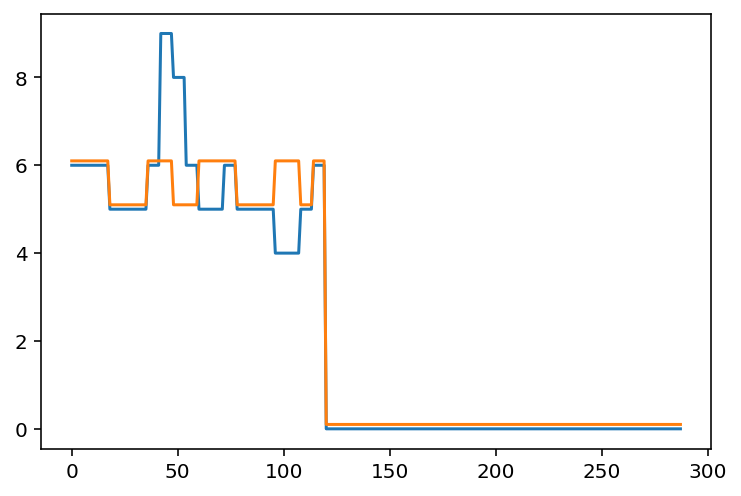

In [59]:
model = model.cpu()
model.eval()
with torch.inference_mode():
  pred = model(src, dec_input)
pred = PackedSequence(pred.data.argmax(dim=-1).float(), pred[1], pred[2], pred[3])
pred = fill_pitches(pred)
pred, batch_lens = pad_packed_sequence(pred, batch_first=True, padding_value=0.0)

idx = 26
plt.plot(padded_tgt[idx])
plt.plot(pred[idx]+0.1)

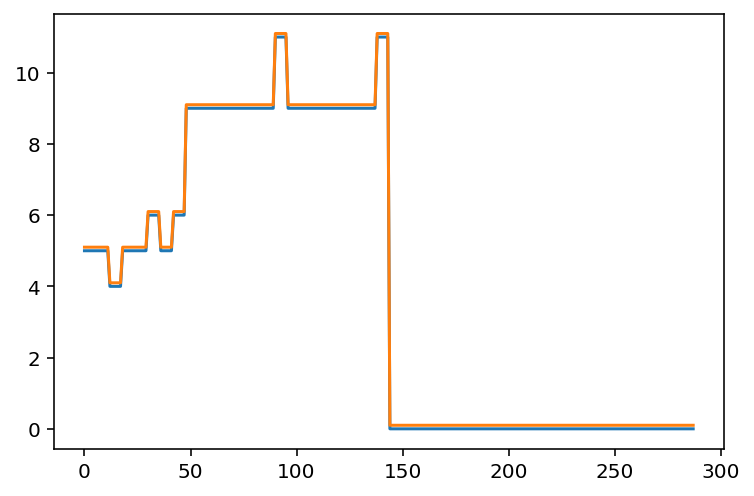

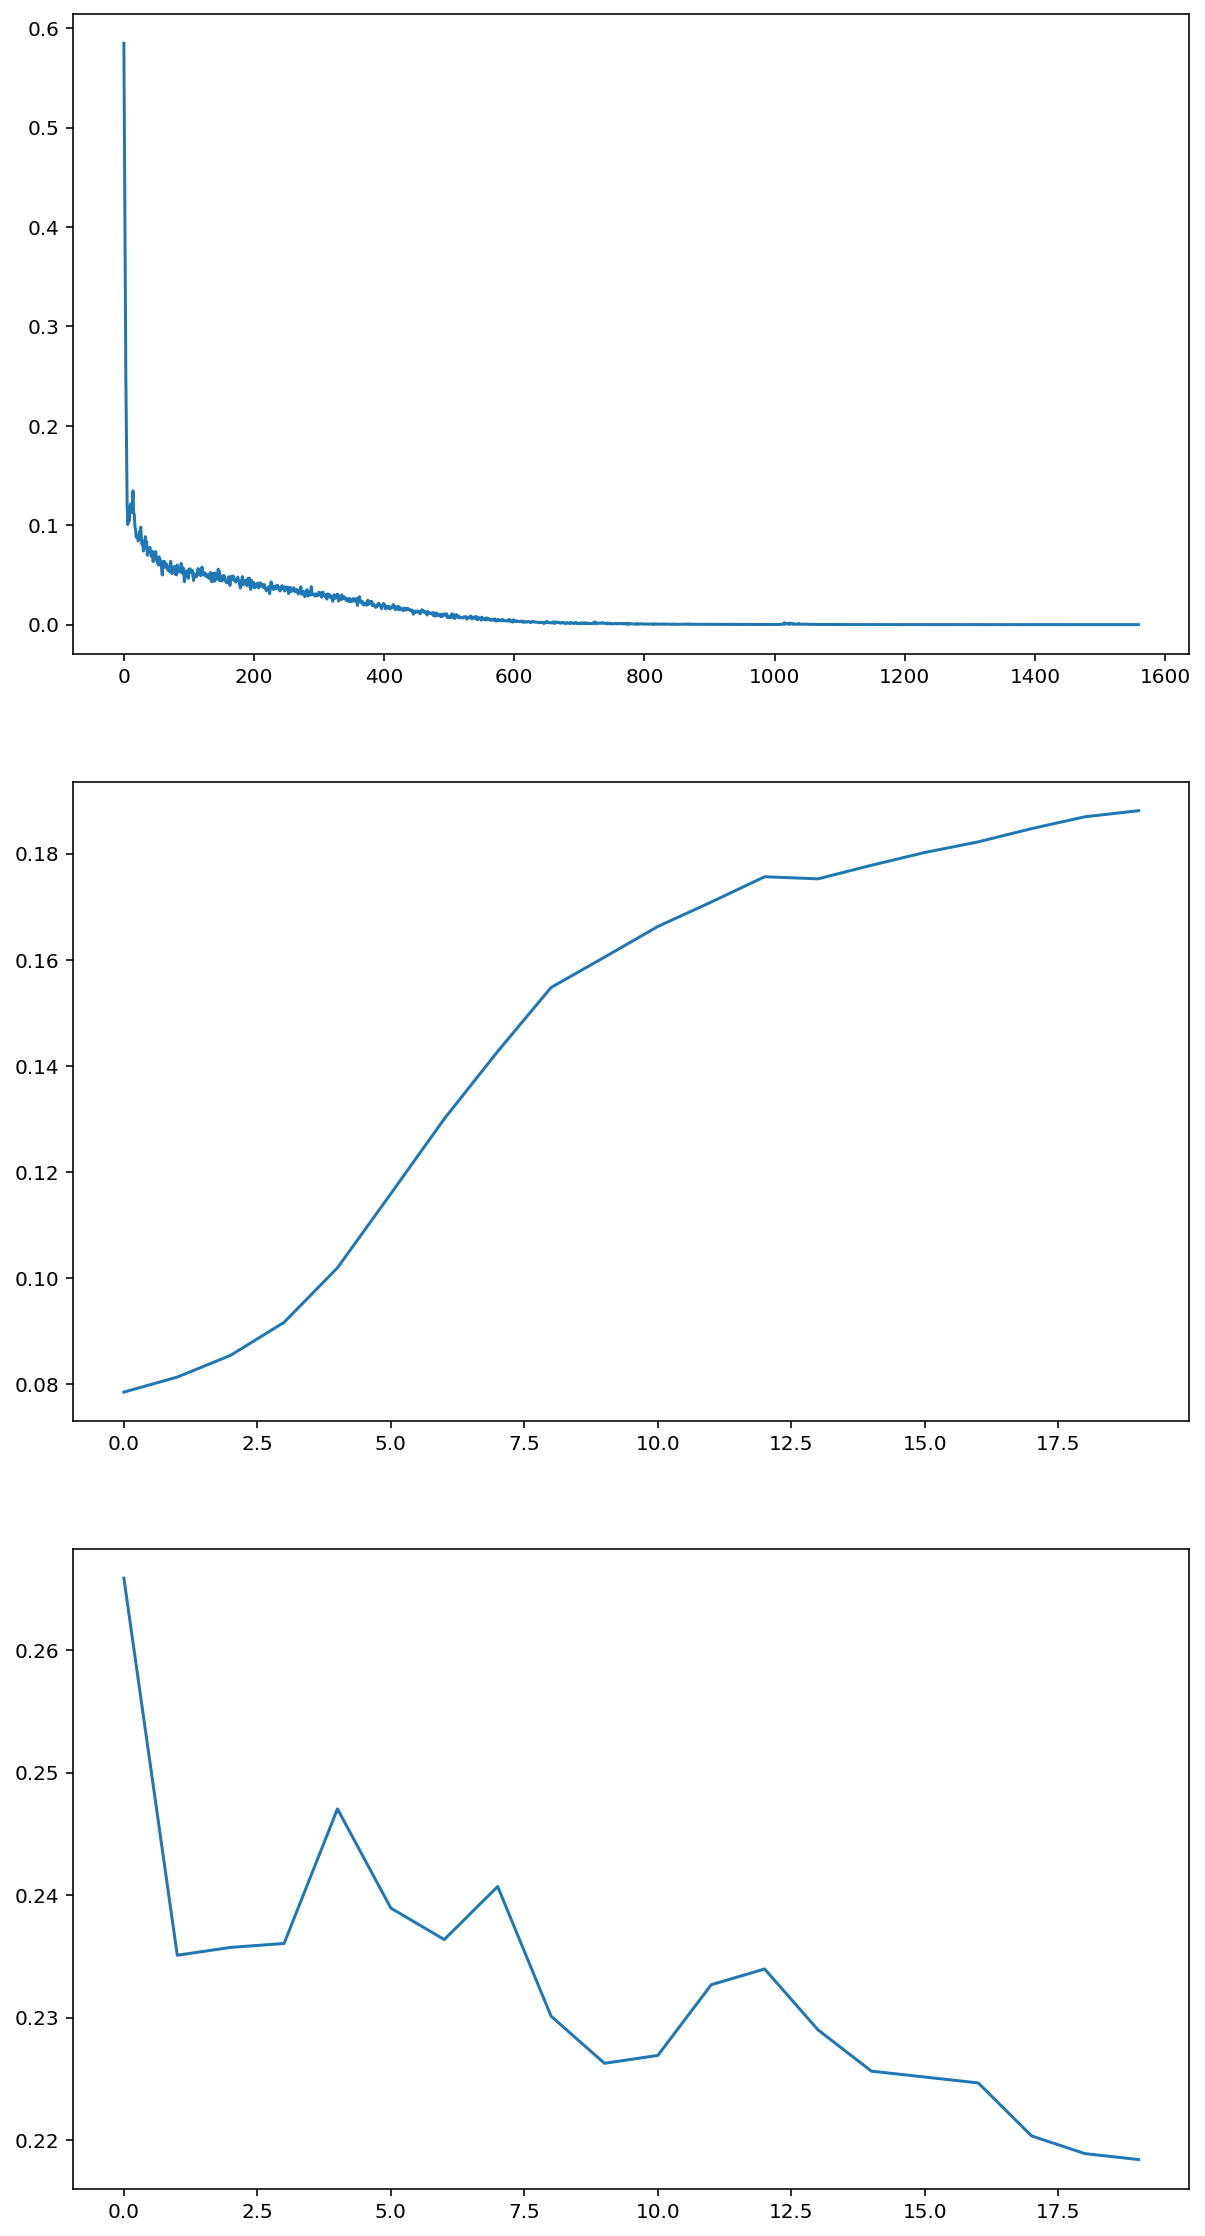

In [62]:
plt.figure(figsize=(10,20))
plt.subplot(3,1,1)
plt.plot(trainer.training_loss)
plt.subplot(3,1,2)
plt.plot(trainer.validation_loss)
plt.subplot(3,1,3)
plt.plot(trainer.validation_acc)

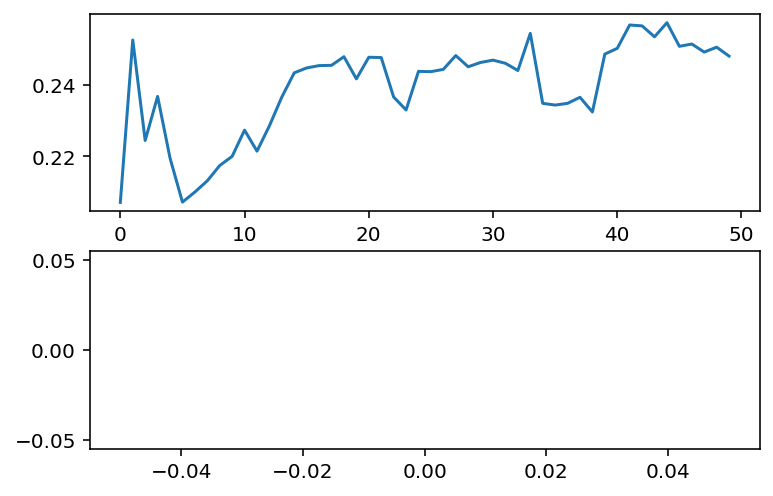

In [6]:
plt.subplot(2,1,1)
plt.plot(trainer.pitch_acc)
plt.subplot(2,1,2)
plt.plot(trainer.dur_acc)

In [ ]:
for batch in valid_loader:
  src, dec_input, shifted_tgt = batch
  break
device = 'cuda'
# model = RollSeq2seq(val_dataset.tokenizer).to(device)
pred = model(src.to(device), dec_input.to(device)).cpu()

In [ ]:
device = 'cpu'
num_tokens = pred.data.shape[0]
print("num_tokens: ", num_tokens)
pitch_acc = float(torch.sum(torch.argmax(pred.data[:, :model.vocab_size[1]], dim=-1) == shifted_tgt.to(device).data[:,0])) / num_tokens
is_onset = shifted_tgt.to(device).data[:,1] != 0
print(is_onset)
onset_acc = float(torch.sum( (pred.data[:, -1] >0.5)[is_onset] == shifted_tgt.to(device).data[:,1][is_onset]))  / is_onset.sum()
onset_acc

num_tokens:  12480
tensor([ True,  True,  True,  ..., False, False, False])


tensor(0.7572)

In [ ]:
pitch_acc, onset_acc

(0.8673878205128205, 0.9444711538461539)

In [ ]:

print(len(pred.data[:, -1:]>0.5))
print(tgt.data.shape)
onset_acc = (pred.data[:, -1:]>0.5)[tgt.data[tgt.data[:, 1]==1]][:, 1] == 1
onset_acc.sum()

9996
torch.Size([9996, 2])


tensor(1077)

In [ ]:
tgt.data[tgt.data[:, 1]==1]

tensor([[ 9,  1],
        [ 9,  1],
        [ 3,  1],
        ...,
        [11,  1],
        [11,  1],
        [11,  1]])

9660

In [ ]:
tgt.data.shape

torch.Size([9996, 2])

In [ ]:
onset_acc = torch.argmax(pred.data[:, -1:], dim=-1)[tgt.data[tgt.data[:, 1]==1]]#[:, 1] == 1
onset_acc
# torch.argmax(pred.data[..., 1], dim=-1)
# tgt.data[tgt.data[:, 1]==1]
# (torch.argmax(pred.data[..., 1]) == tgt.data[tgt.data[:, 1]==1]).sum()

tensor([[0, 0],
        [0, 0],
        [0, 0],
        ...,
        [0, 0],
        [0, 0],
        [0, 0]])

## Inference

In [ ]:
model = QkvRollSeq2seq(val_dataset.tokenizer, hidden_size=32).to(device)
model.load_state_dict(torch.load("best_model.pt"))


In [ ]:
valid_dataset_idx = 30
output_part_idx = 7

sample = valid_loader.dataset[valid_dataset_idx][0]
tokenized_dynamics = val_dataset.tokenized_dynamics
model.to('cpu')
src, output = model.inference(sample, tokenized_dynamics, output_part_idx)
print(output)
decoder = SampingDecoder(model, valid_loader)
src_midi = decoder(src)
output_midi = decoder(output)
src_midi.show()
output_midi.show()

# CNN model!!

In [ ]:
for batch in train_loader:
  break
len(batch)

In [ ]:
model = CNNModel(train_dataset.tokenizer)
src, tgt = batch
out = model(src, tgt)
out.shape

In [ ]:
model(batch)

TypeError: 'CNNModel' object is not callable